In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


os.listdir("E:/dog_cat/data")

C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

['test', 'train', 'val']

Train set:
cats=4000
dogs=4006
Test set:
cats=1012
dogs=1013
Validation set:
cats=3676
dogs=3670


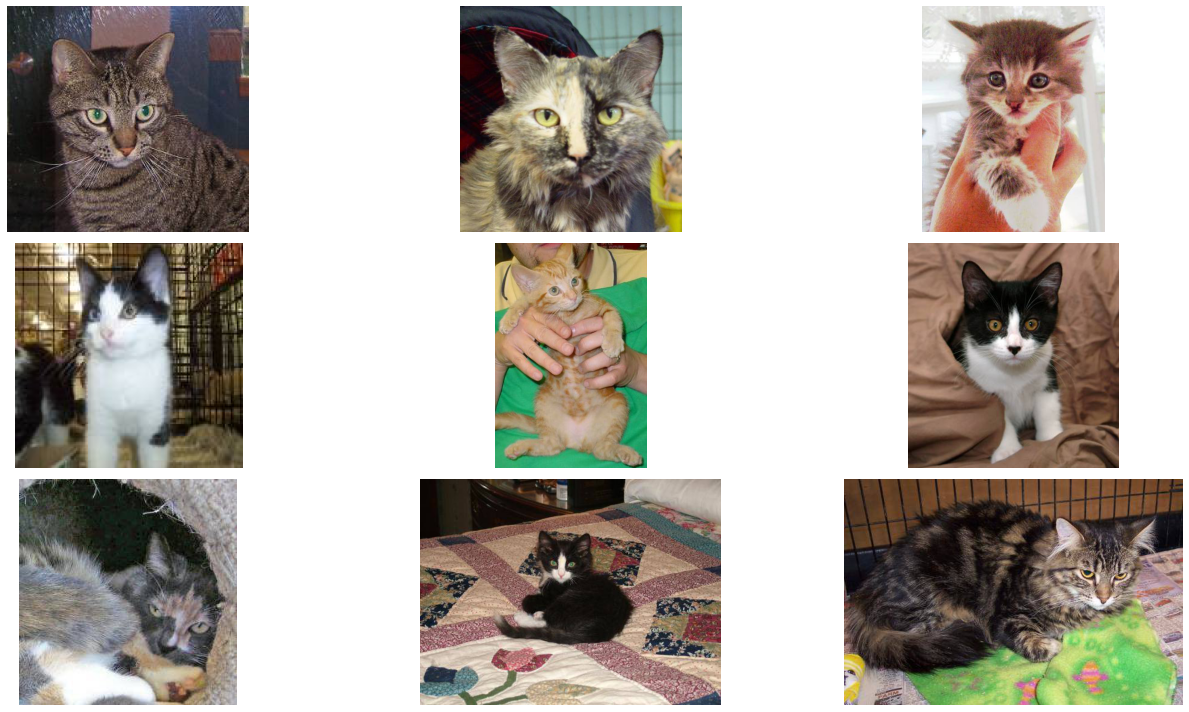

In [2]:
train_dir = "E:/dog_cat/data/train/"
test_dir = "E:/dog_cat/data/test/"
val_dir = "E:/dog_cat/data/val"

print("Train set:\n========================================")
num_cats = len(os.listdir(os.path.join(train_dir, 'cats')))
num_dogs = len(os.listdir(os.path.join(train_dir, 'dogs')))
print(f"cats={num_cats}")
print(f"dogs={num_dogs}")

print("Test set:\n========================================")
print(f"cats={len(os.listdir(os.path.join(test_dir,'cats')))}")
print(f"dogs={len(os.listdir(os.path.join(test_dir, 'dogs')))}")


print("Validation set:\n========================================")
print(f"cats={len(os.listdir(os.path.join(val_dir, 'cats')))}")
print(f"dogs={len(os.listdir(os.path.join(val_dir, 'dogs')))}")

cats = os.listdir("E:/dog_cat/data/train/cats")
cats_dir = "E:/dog_cat/data/train/cats"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(cats_dir, cats[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

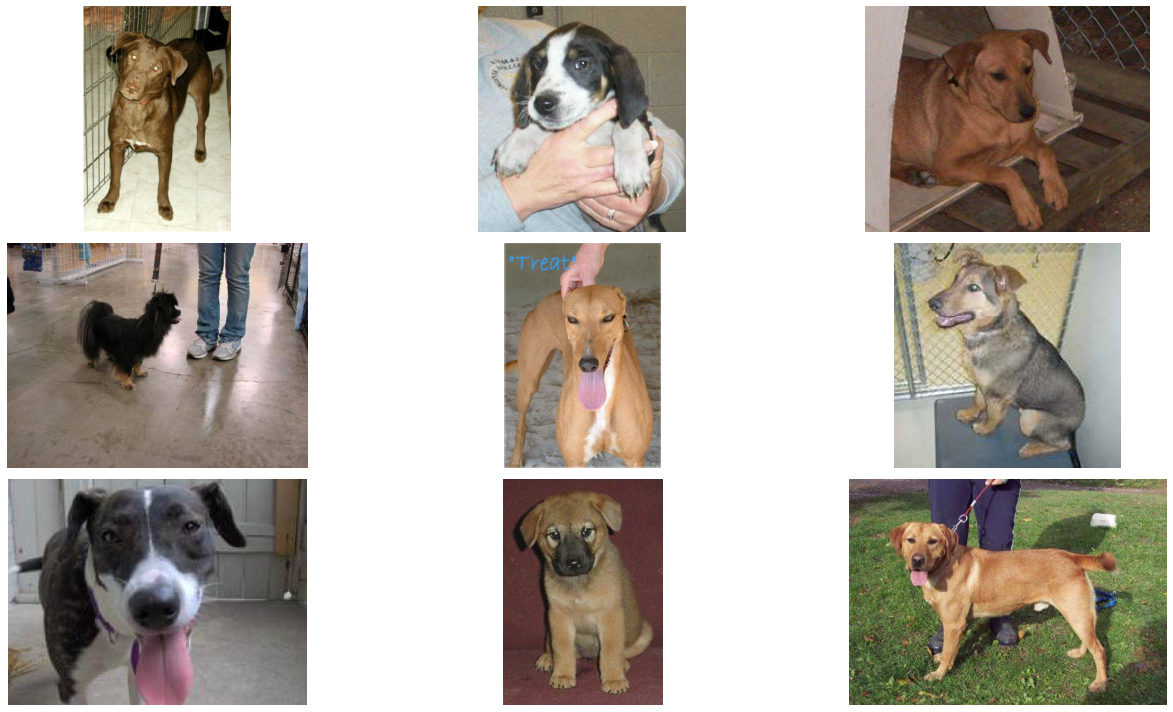

In [3]:
dogs = os.listdir("E:/dog_cat/data/train/dogs")
dogs_dir = "E:/dog_cat/data/train/dogs"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(dogs_dir, dogs[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

# Data Augmentation

In [4]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

Using TensorFlow backend.


In [5]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 8005 images belonging to 2 classes.
Found 7346 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [6]:
# Class weights

weight_for_0 = num_cats / (num_dogs + num_cats)
weight_for_1 = num_dogs / (num_dogs + num_cats)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.50
Weight for class 1: 0.50


# VGG16 Model

In [10]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16


vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')

In [11]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

In [14]:
#Batch normalization 
vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

In [19]:
#SGD optimizer
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
vgg16_model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=METRICS)

In [20]:
r = vgg16_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)

Epoch 1/10
100/100 [==============================] - 361s 4s/step - loss: 0.3540 - accuracy: 0.5675 - precision: 0.5531 - recall: 0.5798 - val_loss: 0.6008 - val_accuracy: 1.0000 - val_precision: 0.5572 - val_recall: 0.5714
Epoch 2/10
100/100 [==============================] - 367s 4s/step - loss: 0.3451 - accuracy: 0.5612 - precision: 0.5521 - recall: 0.5788 - val_loss: 0.4311 - val_accuracy: 0.7600 - val_precision: 0.5548 - val_recall: 0.5803
Epoch 3/10
100/100 [==============================] - 369s 4s/step - loss: 0.3342 - accuracy: 0.5950 - precision: 0.5633 - recall: 0.5840 - val_loss: 0.6190 - val_accuracy: 0.8400 - val_precision: 0.5674 - val_recall: 0.5804
Epoch 4/10
100/100 [==============================] - 372s 4s/step - loss: 0.3416 - accuracy: 0.5875 - precision: 0.5748 - recall: 0.5846 - val_loss: 0.9156 - val_accuracy: 0.8000 - val_precision: 0.5670 - val_recall: 0.5785
Epoch 5/10
100/100 [==============================] - 372s 4s/step - loss: 0.3425 - accuracy: 0.6037

Text(0.5, 1.0, 'Accuracy Evolution')

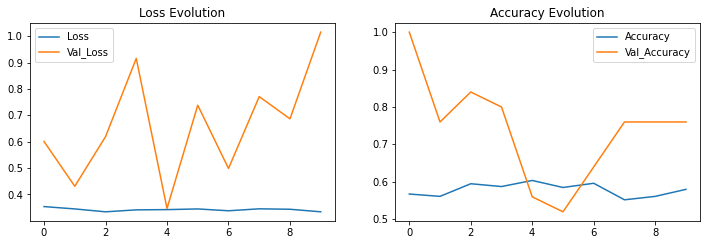

In [21]:
 plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [22]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

2023/2023 [==============================] - 776s 383ms/step
Test Accuracy: 61.49%
1001/1001 [==============================] - 1680s 2s/step
Train Accuracy: 61.86%


https://github.com/nehrjv/Deep-Learning-lab-Assignment/tree/main/ASSESSMENT%204%20-Transfer%20learning